In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from YPR_funcs import *

In [2]:
data = 'Trunc_NASA_S1.csv'
cols = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z']

df = pd.read_csv(data, skipinitialspace=True, usecols=cols)

time = df['Timestamp'].values

# offset time to start at zero
time = time - time[0]
size = time.size

################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

In [3]:
# Just using the raw values directly from the VN
yaw0 = np.array(df['Yaw'].values)
pitch0 = np.array(df['Pitch'].values)
roll0 = np.array(df['Roll'].values)

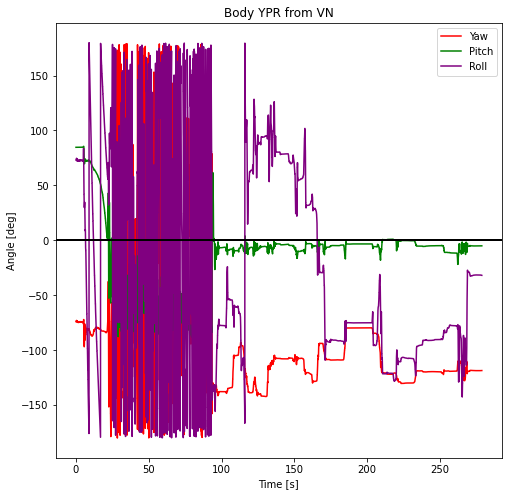

In [4]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, yaw0, color='red', label='Yaw')
ax.plot(time, pitch0, color='green', label='Pitch')
ax.plot(time, roll0, color='purple', label='Roll')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Body YPR from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

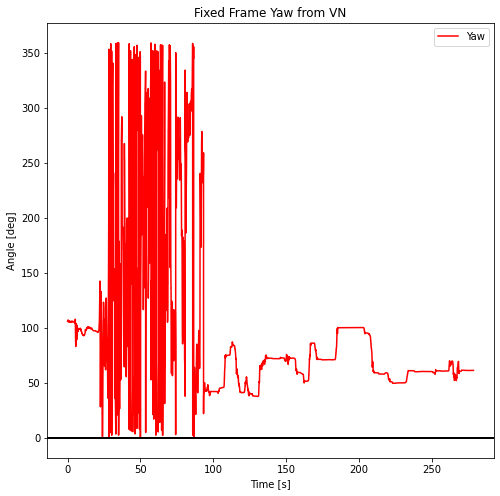

In [5]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, yaw0+180, color='red', label='Yaw')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Fixed Frame Yaw from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

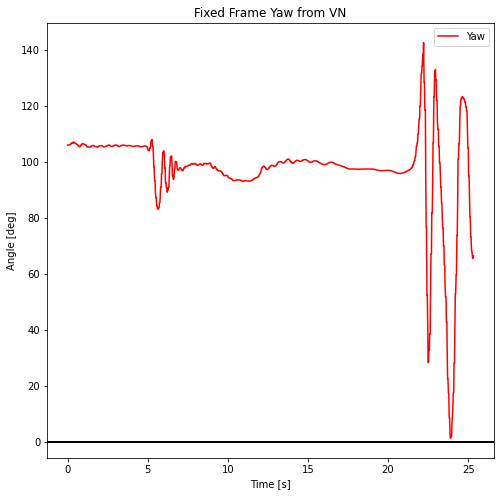

In [53]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time[0:1000], (yaw0+180)[0:1000], color='red', label='Yaw')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Fixed Frame Yaw from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

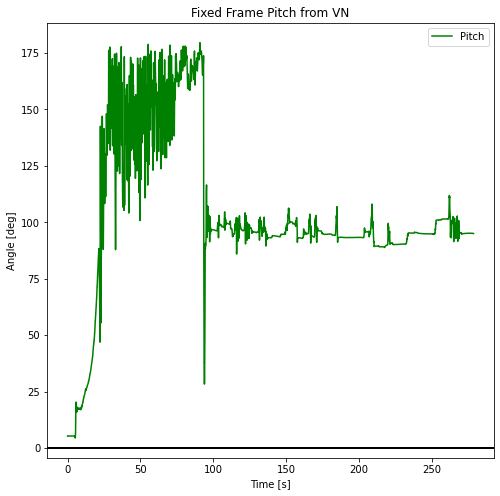

In [36]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, -1*pitch0+90, color='green', label='Pitch')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Fixed Frame Pitch from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

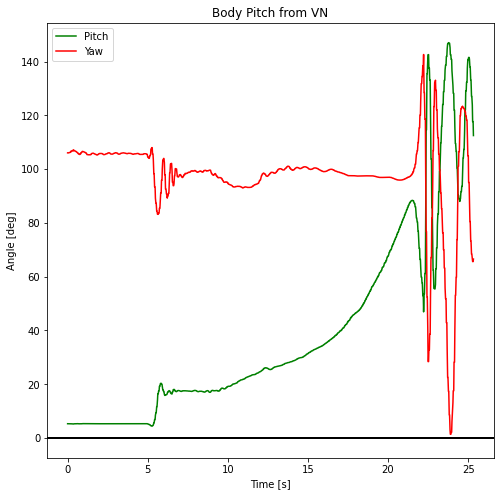

In [54]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time[0:1000], (-1*pitch0+90)[0:1000], color='green', label='Pitch')
plt.axhline(y=0, color='black', linewidth=2)
ax.plot(time[0:1000], (yaw0+180)[0:1000], color='red', label='Yaw')

ax.set_title("Body Pitch from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

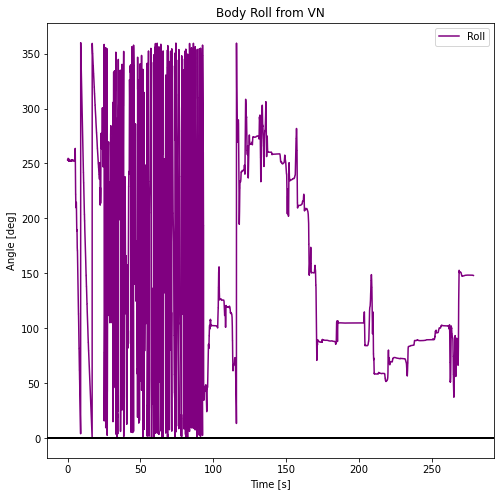

In [50]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time, roll0+180, color='purple', label='Roll')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Body Roll from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

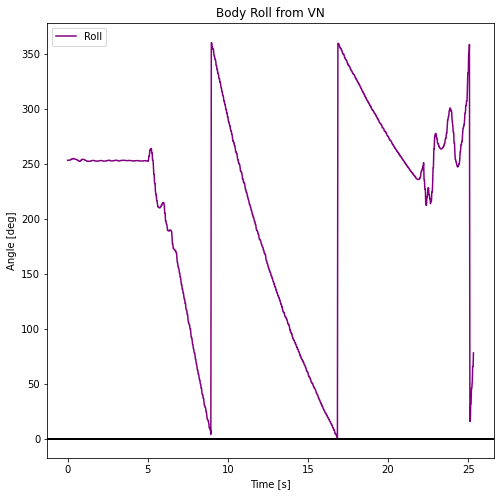

In [51]:
fig = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(time[0:1000], (roll0+180)[0:1000], color='purple', label='Roll')
plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("Body Roll from VN")
ax.set_xlabel('Time [s]')
ax.set_ylabel("Angle [deg]")
ax.legend()
plt.show()

## Original Method

In [13]:
def sind(x):
    return sin(np.deg2rad(x))

def cosd(x):
    return cos(np.deg2rad(x))

def tand(x):
    return tan(np.deg2rad(x))

def acosd(x):
    return np.rad2deg(acos(x))

def nasa_pres(P, P0=101.29, T0=288.08):
    T = T0*((P / P0)**(1 / 5.256)) - 273.1
    h = (T-15.04)/(-0.00649)
    return h

In [14]:
################## DATA FRAME ##################
datafile = 'VADL20_21.csv'
fields = ['Timestamp', 'Pres', 'Temp',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Yaw', 'Pitch', 'Roll']
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
start = 22900
stop = 27000

t_IMU = df['Timestamp'].values[start:stop]
yaw_IMU = df['Yaw'].values[start:stop]
pitch_IMU = df['Pitch'].values[start:stop]
roll_IMU = df['Roll'].values[start:stop]

t_IMU = t_IMU - t_IMU[0]

## Trim to Apogee
# Note that I already did this above with [start:stop]
# *** YAW = ROLL ***
t_array = t_IMU#[0:i_apogee]
gamma_array = yaw_IMU#[0:i_apogee]
alpha_array = pitch_IMU#[0:i_apogee]
beta_array = roll_IMU#[0:i_apogee]

N = len(t_array)

# Preallocate
angle_array = np.zeros(N)  # angle
n_array = np.zeros((3,N))   # axis
theta_array = np.zeros(N)   # resolved angle

## Calculate
# iterate until apogee
for i in range(N):
    
    alpha = alpha_array[i]
    beta = beta_array[i]
    gamma = gamma_array[i]
    
    # yaw
    R_alpha = np.array([[1, 0, 0],
               [0, cosd(alpha), -sind(alpha)],
               [0, sind(alpha), cosd(alpha)]])
           
    # pitch
    R_beta = np.array([[cosd(beta), 0, sind(beta)],
              [0, 1, 0],
              [-sind(beta), 0, cosd(beta)]])
          
    # roll
    R_gamma = np.array([[cosd(gamma), -sind(gamma), 0],
               [sind(gamma), cosd(gamma), 0],
               [0, 0, 1]])
    
    R = R_gamma*R_beta*R_alpha
    #R = R_gamma
    
    # calculate angle
    angle = acosd((np.trace(R) - 1)/2)
    angle_array[i] = angle

    # theta
    theta = acosd(np.dot(R[:,2], [0, 0, 1]))
    theta_array[i] = theta
    
# Theta vs Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_pre_apog = t_array[t_array < 17.21]
i_apogee = t_pre_apog.shape[0]
pitch_array_apog = pitch_array[0:i_apogee]

# Pitch vs Time
gamma_array = gamma_array[0:i_apogee]

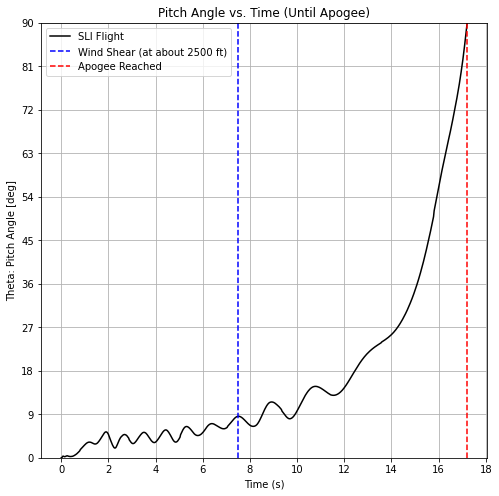

In [15]:
# Theta vs. Time
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(t_pre_apog, pitch_array_apog, color='black', label='SLI Flight')
l2 = plt.axvline(x=7.5, color='blue', linestyle="--", label='Wind Shear (at about 2500 ft)')
l3 = plt.axvline(x=17.21, color='red', linestyle="--", label='Apogee Reached')

plt.grid()
plt.yticks(np.linspace(0,90, num=11))
plt.ylim((0, 90))
plt.xticks(np.linspace(0,18, num=10))


ax.set_title("Pitch Angle vs. Time (Until Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()

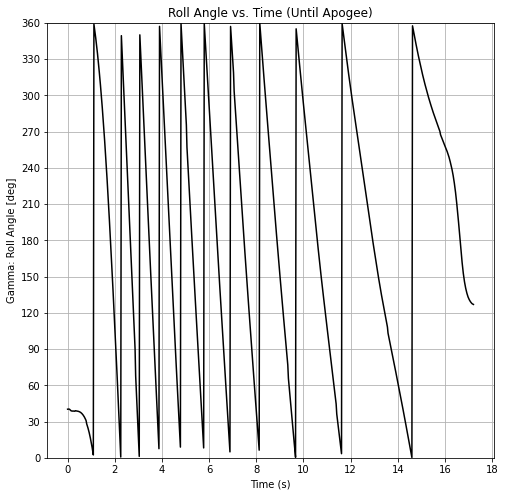

In [16]:
## Roll Plot

# Roll vs. Time
fig2 = plt.figure(2, figsize=(8,8))
ax2 = plt.subplot(111)
l1 = ax2.plot(t_pre_apog, gamma_array+180, color='black', label='SLI Flight')

plt.grid()
plt.ylim((0, 360))
plt.yticks(np.linspace(0,360, num=13))
plt.xticks(np.linspace(0,18, num=10))

ax2.set_title("Roll Angle vs. Time (Until Apogee)")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel("Gamma: Roll Angle [deg]")
plt.show()

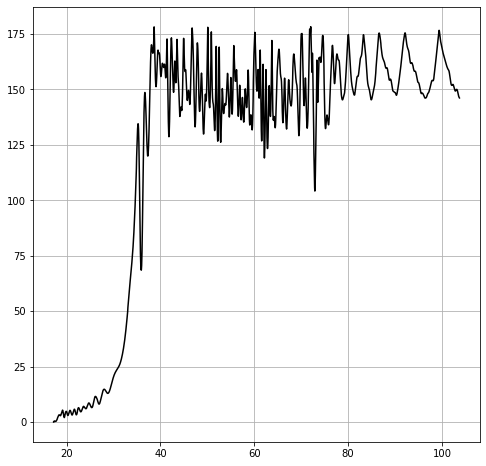

In [17]:
# Theta vs. Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_post_apog = t_array[t_array > 17.21]
i_post_apogee = t_post_apog.shape[0]
pitch_array_post_apog = pitch_array[0:i_post_apogee]

fig5 = plt.figure(5, figsize=(8,8))
ax5 = plt.subplot(111)
l5 = ax5.plot(t_post_apog, pitch_array_post_apog, color='black', label='SLI Flight')

plt.grid()
#plt.yticks(np.linspace(0,90, num=11))
#plt.ylim((0, 90))
#plt.xticks(np.linspace(0,18, num=10))


ax.set_title("Pitch Angle vs. Time (Post Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()

## Original Analysis Applied to NASA Data: Pre-Apogee: SIFT 1

In [47]:
################## DATA FRAME ##################
datafile = 'Trunc_NASA_S1.csv'
fields = ['Timestamp', 'Pres',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Yaw', 'Pitch', 'Roll']
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
start = 170
i_apogee = 1400#850 # FOR SIFT 1 ONLY
########################################################

def convert_abg(bYPR):
    # Normally, alpha beta gamma are yaw pitch roll
    # Our IMU placement is such that the roll axis of the IMU is the pitch of the vehicle
    # So let's just switch things around
    
    gamma = bYPR[0]  # Yaw
    alpha = bYPR[1]  # Pitch
    beta = bYPR[2]  # Roll

    # Essentially we just returned a switched around version of bYPR
    return np.array([alpha, beta, gamma])

t_IMU = df['Timestamp'].values[start:i_apogee]
yaw_IMU = df['Yaw'].values[start:i_apogee]
pitch_IMU = df['Pitch'].values[start:i_apogee]
roll_IMU = df['Roll'].values[start:i_apogee]

t_IMU = t_IMU - t_IMU[0]

## Trim to Apogee
# *** YAW = ROLL ***
t_array = t_IMU
#alpha_array = yaw_IMU
#beta_array = pitch_IMU
#gamma_array = roll_IMU

alpha_array = yaw_IMU
beta_array = roll_IMU
gamma_array = pitch_IMU

N = len(t_array)

# Preallocate
angle_array = np.zeros(N)  # angle
n_array = np.zeros((3,N))   # axis
theta_array = np.zeros(N)   # resolved angle

## Calculate
# iterate until apogee
for i in range(N):
    
    alpha = alpha_array[i]
    beta = beta_array[i]
    gamma = gamma_array[i]
    
    # yaw
    R_alpha = np.array([[1, 0, 0],
               [0, cosd(alpha), -sind(alpha)],
               [0, sind(alpha), cosd(alpha)]])
           
    # pitch
    R_beta = np.array([[cosd(beta), 0, sind(beta)],
              [0, 1, 0],
              [-sind(beta), 0, cosd(beta)]])
          
    # roll
    R_gamma = np.array([[cosd(gamma), -sind(gamma), 0],
               [sind(gamma), cosd(gamma), 0],
               [0, 0, 1]])
    
    R = R_gamma*R_beta*R_alpha
    #R = R_gamma
    
    # calculate angle
    angle = acosd((np.trace(R) - 1)/2)
    angle_array[i] = angle

    # theta
    theta = acosd(np.dot(R[:,2], [0, 0, 1]))
    theta_array[i] = theta
    
# Theta vs Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_pre_apog = t_array[t_array < 17.21]
i_apogee = t_pre_apog.shape[0]
pitch_array_apog = pitch_array[0:i_apogee]

# Pitch vs Time
gamma_array = gamma_array[0:i_apogee]

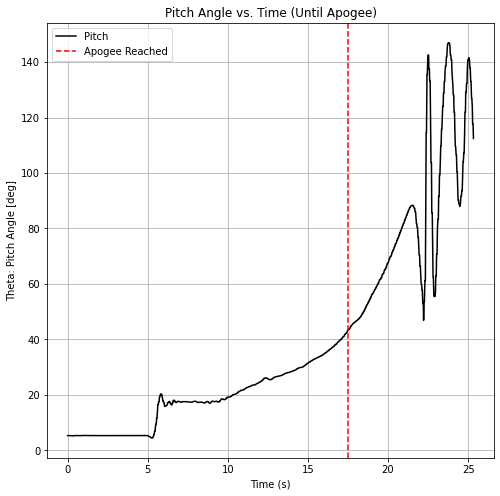

In [55]:
# Theta vs. Time
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
#l1 = ax.plot(t_pre_apog, pitch_array_apog, color='black', label='SLI Flight')
#l1 = ax.plot(t_array, pitch_array, color='black', label='SLI Flight')
ax.plot(time[0:1000], (-1*pitch0+90)[0:1000], color='black', label='Pitch')
#l2 = plt.axvline(x=7.5, color='blue', linestyle="--", label='Wind Shear (at about 2500 ft)')
l3 = plt.axvline(x=17.5, color='red', linestyle="--", label='Apogee Reached')

plt.grid()
#plt.yticks(np.linspace(0,90, num=11))
#plt.ylim((0, 90))
#plt.xticks(np.linspace(0,18, num=10))

ax.set_title("Pitch Angle vs. Time (Until Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()

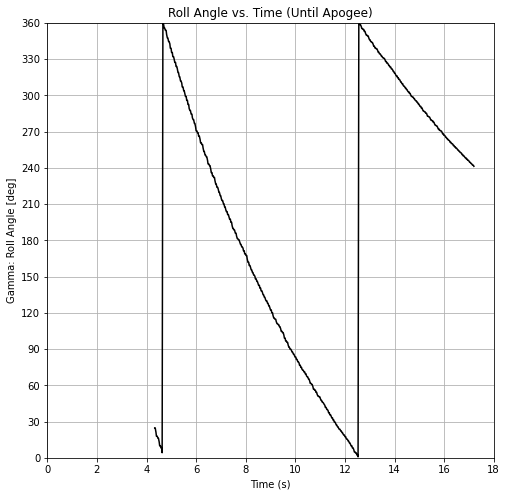

In [42]:
## Roll Plot

# Roll vs. Time
fig2 = plt.figure(2, figsize=(8,8))
ax2 = plt.subplot(111)
l1 = ax2.plot(t_pre_apog[start:i_apogee], beta_array[start:i_apogee]+180, color='black', label='SLI Flight')

plt.grid()
plt.ylim((0, 360))
plt.yticks(np.linspace(0,360, num=13))
plt.xticks(np.linspace(0,18, num=10))

ax2.set_title("Roll Angle vs. Time (Until Apogee)")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel("Gamma: Roll Angle [deg]")
plt.show()

## Original Analysis Applied to NASA Data: Pre-Apogee: SIFT 2

In [21]:
################## DATA FRAME ##################
datafile = 'Trunc_NASA_S2.csv'
fields = ['Timestamp', 'Pres',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Yaw', 'Pitch', 'Roll']
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
start = 900
i_apogee = 1580
########################################################

t_IMU = df['Timestamp'].values[start:i_apogee]
yaw_IMU = df['Yaw'].values[start:i_apogee]
pitch_IMU = df['Pitch'].values[start:i_apogee]
roll_IMU = df['Roll'].values[start:i_apogee]

t_IMU = t_IMU - t_IMU[0]

## Trim to Apogee
# *** YAW = ROLL ***
t_array = t_IMU
gamma_array = yaw_IMU
alpha_array = pitch_IMU
beta_array = roll_IMU

N = len(t_array)

# Preallocate
angle_array = np.zeros(N)  # angle
n_array = np.zeros((3,N))   # axis
theta_array = np.zeros(N)   # resolved angle

## Calculate
# iterate until apogee
for i in range(N):
    
    alpha = alpha_array[i]
    beta = beta_array[i]
    gamma = gamma_array[i]
    
    # yaw
    R_alpha = np.array([[1, 0, 0],
               [0, cosd(alpha), -sind(alpha)],
               [0, sind(alpha), cosd(alpha)]])
           
    # pitch
    R_beta = np.array([[cosd(beta), 0, sind(beta)],
              [0, 1, 0],
              [-sind(beta), 0, cosd(beta)]])
          
    # roll
    R_gamma = np.array([[cosd(gamma), -sind(gamma), 0],
               [sind(gamma), cosd(gamma), 0],
               [0, 0, 1]])
    
    R = R_gamma*R_beta*R_alpha
    #R = R_gamma
    
    # calculate angle
    angle = acosd((np.trace(R) - 1)/2)
    angle_array[i] = angle

    # theta
    theta = acosd(np.dot(R[:,2], [0, 0, 1]))
    theta_array[i] = theta
    
# Theta vs Time
pitch_array = -1*theta_array
pitch_array = pitch_array - pitch_array[0]
t_pre_apog = t_array[t_array < 17.21]
i_apogee = t_pre_apog.shape[0]
pitch_array_apog = pitch_array[0:i_apogee]

# Pitch vs Time
gamma_array = gamma_array[0:i_apogee]

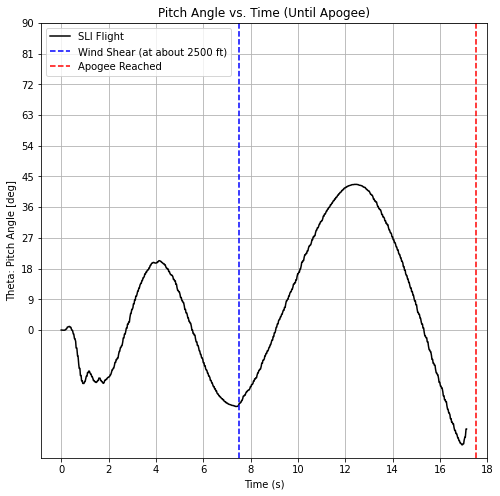

In [22]:
# Theta vs. Time
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l1 = ax.plot(t_pre_apog, pitch_array_apog, color='black', label='SLI Flight')
l2 = plt.axvline(x=7.5, color='blue', linestyle="--", label='Wind Shear (at about 2500 ft)')
l3 = plt.axvline(x=17.5, color='red', linestyle="--", label='Apogee Reached')

plt.grid()
plt.yticks(np.linspace(0,90, num=11))
#plt.ylim((0, 90))
plt.xticks(np.linspace(0,18, num=10))


ax.set_title("Pitch Angle vs. Time (Until Apogee)")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Theta: Pitch Angle [deg]")
ax.legend(loc=2)
plt.show()